In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!export LC_ALL=C.UTF-8
!export LANG=C.UTF-8
!ls "/content/drive/MyDrive/My First Project.v15i.yolov11"


data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [5]:
!pip install ultralytics torch torchvision opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 976.9/976.9 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [6]:
!pip install ultralytics

In [7]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
import torch
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os
import glob
from PIL import Image
import numpy as np

In [9]:
DATASET_PATH = "/content/drive/MyDrive/My First Project.v15i.yolov11"  # Change to your dataset path
IMG_SIZE = 416  # Image size for training

import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Example Vision Transformer

# Load YOLOv10m model
model = YOLO("yolo11m.pt")




100%|██████████| 38.8M/38.8M [00:00<00:00, 42.3MB/s]


In [10]:
import torch
import torch.nn as nn
from torchvision.models.vision_transformer import vit_b_16  # Small Vision Transformer

class HybridBackbone(nn.Module):
    def __init__(self, yolo_backbone, transformer):
        super().__init__()
        self.yolo_backbone = yolo_backbone
        self.transformer = transformer

    def forward(self, x):
        # Extract features using YOLO's CNN backbone
        cnn_features = self.yolo_backbone(x)

        # Transformer expects a different input shape, so adjust it
        b, c, h, w = cnn_features.shape
        cnn_features = cnn_features.view(b, c, -1).permute(2, 0, 1)  # Reshape for transformer input

        # Extract transformer features
        transformer_features = self.transformer(cnn_features)

        # Reshape back to CNN format
        transformer_features = transformer_features.permute(1, 2, 0).view(b, c, h, w)

        return transformer_features

# Extract YOLO's original backbone
yolo_backbone = model.model.model[0]  # This extracts YOLO's backbone

# Load a pretrained Vision Transformer
transformer = vit_b_16(pretrained=True)
transformer.heads = nn.Identity()  # Remove classification head

# Create a new hybrid backbone
hybrid_backbone = HybridBackbone(yolo_backbone, transformer)

# Replace YOLO's backbone with the hybrid version
model.model.model[0] = hybrid_backbone


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 104MB/s]


In [11]:
model.train(
    epochs=50,
    batch=16,
    imgsz=416,
    device="cuda" if torch.cuda.is_available() else "cpu",
    patience=6,  # Early stopping with patience 6

    data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml",
)

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml, epochs=50, time=None, patience=6, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_label

100%|██████████| 755k/755k [00:00<00:00, 90.5MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    111872  ultralytics.nn.modules.block.C3k2            [128, 256, 1, True, 0.25]     
  3                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  4                  -1  1    444928  ultralytics.nn.modules.block.C3k2            [256, 512, 1, True, 0.25]     
  5                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  6                  -1  1   1380352  ultralytics.nn.modules.block.C3k2            [512, 512, 1, True]           
  7                  -1  1   2360320  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 267MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/train/labels.cache... 2436 images, 426 backgrounds, 0 corrupt: 100%|██████████| 2442/2442 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.77G      1.954      3.344      1.919         35        416: 100%|██████████| 153/153 [11:55<00:00,  4.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        266        295      0.158     0.0328     0.0274    0.00951



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.45G       2.09       3.19      2.004         15        416: 100%|██████████| 153/153 [00:51<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]


                   all        266        295     0.0881      0.111     0.0235     0.0084

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.49G      2.124      3.229      2.013         19        416: 100%|██████████| 153/153 [00:50<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]


                   all        266        295      0.121      0.113     0.0391     0.0165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.51G      2.056      3.086      1.956         29        416: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]


                   all        266        295      0.161      0.172      0.055     0.0176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.58G      2.003      3.038       1.89         20        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


                   all        266        295      0.218      0.177     0.0948     0.0399

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.64G      1.982      2.973      1.901         19        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.25it/s]

                   all        266        295      0.317      0.182      0.173     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.7G      1.903      2.831      1.835         15        416: 100%|██████████| 153/153 [00:49<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

                   all        266        295       0.21      0.272       0.21     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       4.7G      1.866      2.784      1.815         19        416: 100%|██████████| 153/153 [00:49<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.21it/s]


                   all        266        295      0.277      0.235       0.21      0.094

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       4.7G      1.821      2.701      1.776         33        416: 100%|██████████| 153/153 [00:49<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


                   all        266        295      0.285      0.262      0.241      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       4.7G      1.816      2.677       1.78         14        416: 100%|██████████| 153/153 [00:50<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]


                   all        266        295      0.245      0.255      0.242      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       4.7G      1.801      2.628      1.765         24        416: 100%|██████████| 153/153 [00:53<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.85it/s]

                   all        266        295      0.329       0.26      0.243      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       4.7G       1.78      2.567      1.733         23        416: 100%|██████████| 153/153 [00:49<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]


                   all        266        295      0.272      0.318      0.262      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.95G      1.741      2.553      1.729         17        416: 100%|██████████| 153/153 [00:50<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.41it/s]

                   all        266        295      0.242       0.29      0.259      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         5G       1.71      2.496      1.699         16        416: 100%|██████████| 153/153 [00:50<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        266        295      0.286      0.355      0.273      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         5G      1.707      2.457      1.698         22        416: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

                   all        266        295      0.331      0.366       0.29      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         5G      1.697      2.412      1.695         19        416: 100%|██████████| 153/153 [00:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.33it/s]

                   all        266        295      0.329       0.34      0.291      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         5G      1.688      2.414      1.684         26        416: 100%|██████████| 153/153 [00:49<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


                   all        266        295      0.357      0.379       0.32      0.143

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         5G      1.653       2.35      1.663         24        416: 100%|██████████| 153/153 [00:48<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        266        295      0.323      0.315      0.304      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         5G      1.668      2.337      1.668         22        416: 100%|██████████| 153/153 [00:48<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]


                   all        266        295       0.36      0.383      0.344      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         5G      1.631      2.275      1.654         21        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.75it/s]

                   all        266        295      0.377      0.378      0.356      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         5G      1.636      2.308      1.662         25        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        266        295      0.399      0.405      0.372       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         5G      1.606      2.239      1.641         17        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.36it/s]

                   all        266        295      0.491      0.386      0.387      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         5G      1.624      2.202      1.651         20        416: 100%|██████████| 153/153 [00:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.24it/s]


                   all        266        295      0.515      0.335      0.394      0.188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         5G      1.584      2.176      1.616         20        416: 100%|██████████| 153/153 [00:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.06it/s]

                   all        266        295      0.458      0.404       0.39      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         5G       1.57      2.145      1.606         35        416: 100%|██████████| 153/153 [00:49<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all        266        295      0.434      0.416      0.399      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         5G      1.573      2.113      1.609         20        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.53it/s]


                   all        266        295      0.427      0.415      0.414      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         5G      1.545       2.07      1.592         15        416: 100%|██████████| 153/153 [00:48<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.25it/s]


                   all        266        295      0.519      0.446      0.439      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         5G      1.559      2.079      1.609         24        416: 100%|██████████| 153/153 [00:49<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]


                   all        266        295      0.528      0.418      0.443      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         5G       1.53      2.041      1.589         19        416: 100%|██████████| 153/153 [00:49<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.77it/s]

                   all        266        295      0.493      0.422      0.417      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         5G       1.54      2.009      1.577         22        416: 100%|██████████| 153/153 [00:49<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

                   all        266        295      0.489      0.409       0.43      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         5G      1.529      1.988      1.573         19        416: 100%|██████████| 153/153 [00:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        266        295      0.547      0.466      0.487      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         5G      1.514       1.98      1.565         15        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.58it/s]

                   all        266        295      0.583      0.449      0.475      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         5G      1.516      1.975      1.557         17        416: 100%|██████████| 153/153 [00:49<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.33it/s]

                   all        266        295       0.45      0.442       0.44      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         5G      1.475      1.879      1.536         32        416: 100%|██████████| 153/153 [00:50<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.37it/s]

                   all        266        295        0.5       0.49      0.467      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         5G      1.453      1.853      1.536         10        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        266        295      0.535      0.525      0.518      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         5G       1.45      1.802      1.512         21        416: 100%|██████████| 153/153 [00:51<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all        266        295       0.49      0.546      0.526      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         5G      1.447      1.821      1.507         17        416: 100%|██████████| 153/153 [00:50<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.27it/s]

                   all        266        295      0.556      0.512      0.512      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         5G       1.44      1.791      1.511         18        416: 100%|██████████| 153/153 [00:50<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.36it/s]

                   all        266        295      0.542       0.54       0.54      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         5G      1.426      1.781      1.506         33        416: 100%|██████████| 153/153 [00:51<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.23it/s]

                   all        266        295      0.494      0.535      0.512      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         5G      1.409      1.755      1.504         23        416: 100%|██████████| 153/153 [00:51<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.25it/s]

                   all        266        295      0.517      0.533      0.514      0.278


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         5G      1.439      1.621      1.562         11        416: 100%|██████████| 153/153 [00:51<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

                   all        266        295      0.557      0.522      0.519      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         5G      1.413      1.545      1.546          8        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        266        295      0.587      0.516      0.556      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         5G        1.4      1.479       1.53          6        416: 100%|██████████| 153/153 [00:49<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.30it/s]

                   all        266        295      0.588      0.529      0.537      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         5G      1.378      1.434      1.517          9        416: 100%|██████████| 153/153 [00:50<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

                   all        266        295      0.591      0.556      0.549      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         5G      1.356      1.417      1.498         15        416: 100%|██████████| 153/153 [00:50<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.16it/s]

                   all        266        295      0.578       0.58      0.566      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         5G      1.348      1.401      1.492          8        416: 100%|██████████| 153/153 [00:49<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]

                   all        266        295      0.585       0.56      0.568      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         5G      1.322      1.366      1.461         12        416: 100%|██████████| 153/153 [00:49<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.34it/s]

                   all        266        295      0.611      0.543      0.563      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         5G      1.298      1.346      1.461         11        416: 100%|██████████| 153/153 [00:49<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        266        295      0.608       0.62      0.591      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         5G      1.295      1.306      1.449          9        416: 100%|██████████| 153/153 [00:50<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.15it/s]

                   all        266        295      0.621       0.57      0.584      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         5G      1.282      1.286      1.446         12        416: 100%|██████████| 153/153 [00:50<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.19it/s]

                   all        266        295      0.663      0.591      0.596      0.327



50 epochs completed in 0.952 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 40.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.43it/s]


                   all        266        295      0.662      0.589      0.597      0.326
                 cloth         49         68      0.623      0.632      0.601      0.352
                 glass         60         60      0.801       0.75      0.768      0.395
                 metal         45         55      0.672      0.436      0.474      0.254
               plastic         80        112      0.551      0.536      0.543      0.304
Speed: 0.3ms preprocess, 5.2ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c39be355c50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

In [12]:
metrics = model.val()  # Validate the model

# Extract values correctly
precision = metrics.box.p.mean()  # Mean Precision
recall = metrics.box.r.mean()  # Mean Recall
map50 = metrics.box.map50  # Mean Average Precision @ 50
map50_95 = metrics.box.map  # Mean Average Precision @ 50-95

# Print metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, mAP@50: {map50:.4f}, mAP@50-95: {map50_95:.4f}")

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/valid/labels.cache... 266 images, 42 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]


                   all        266        295      0.663      0.591      0.594      0.326
                 cloth         49         68      0.627      0.642      0.602      0.353
                 glass         60         60      0.801       0.75      0.761      0.392
                 metal         45         55      0.675      0.436      0.471      0.255
               plastic         80        112      0.551      0.536      0.544      0.303
Speed: 1.6ms preprocess, 11.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train2
Precision: 0.6633, Recall: 0.5910, mAP@50: 0.5943, mAP@50-95: 0.3258



0: 416x416 1 metal, 21.7ms
Speed: 4.1ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 416)


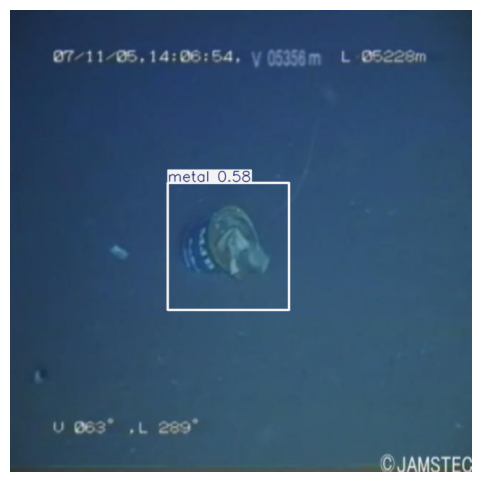

In [13]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

def visualize_results(img_path, model):
    img = Image.open(img_path)
    results = model(img)

    # Extract the first result and get the plotted image
    result_img = results[0].plot()

    # Convert image to NumPy array if it's not already
    result_img = np.array(result_img)

    # Convert BGR (OpenCV default) to RGB for correct display in matplotlib
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

    # Show image with bounding boxes
    plt.figure(figsize=(6,6))
    plt.imshow(result_img)
    plt.axis("off")
    plt.show()
    plt.pause(0.001)  # Force display update
    plt.close()  # Prevent duplicate figures

# Load test images
test_images = glob.glob("/content/drive/MyDrive/My First Project.v15i.yolov11/test/images/*.jpg")

# Run visualization
if test_images:
    visualize_results(test_images[200], model)
else:
    print("No test images found.")

In [14]:
import glob
model_files = glob.glob("/content/runs/detect/*/weights/best.pt")
print("Available model files:", model_files)

Available model files: ['/content/runs/detect/train/weights/best.pt']


In [15]:
import glob

# List all training runs
train_folders = glob.glob("/content/runs/detect/*/")

print("Available training runs:")
for folder in train_folders:
    print(folder)

Available training runs:
/content/runs/detect/train/
/content/runs/detect/train2/


In [16]:
import glob

# Check logs inside different training folders
for folder in train_folders:
    log_files = glob.glob(folder + "/*.csv")
    if log_files:
        print(f"✅ Logs found in: {folder}")
        print(log_files)
    else:
        print(f"❌ No CSV logs found in: {folder}")

✅ Logs found in: /content/runs/detect/train/
['/content/runs/detect/train/results.csv']
❌ No CSV logs found in: /content/runs/detect/train2/


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


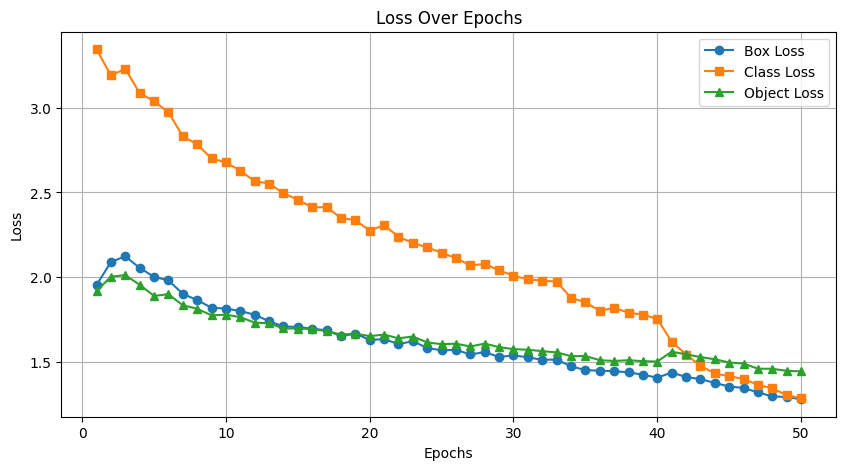

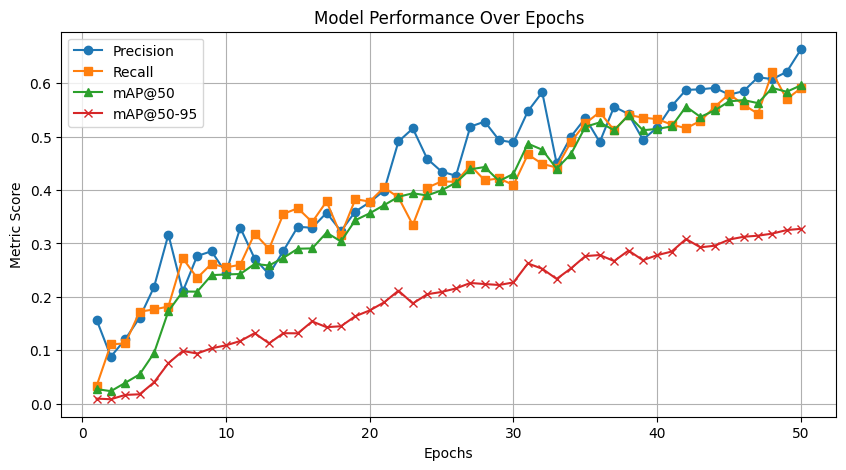

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Enable inline plotting for Jupyter Notebook
%matplotlib inline

# Load the CSV file
csv_path = "/content/runs/detect/train/results.csv"
df = pd.read_csv(csv_path)

# Print column names to check available metrics
print("Available columns:", df.columns)

# ✅ Force Matplotlib to display the figures
def plot_loss():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["train/box_loss"], label="Box Loss", marker='o')
    plt.plot(df["epoch"], df["train/cls_loss"], label="Class Loss", marker='s')
    plt.plot(df["epoch"], df["train/dfl_loss"], label="Object Loss", marker='^')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

def plot_accuracy():
    plt.figure(figsize=(10, 5))
    plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision", marker='o')
    plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall", marker='s')
    plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@50", marker='^')
    plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@50-95", marker='x')

    plt.xlabel("Epochs")
    plt.ylabel("Metric Score")
    plt.title("Model Performance Over Epochs")
    plt.legend()
    plt.grid()
    plt.show(block=True)  # ✅ Forces Jupyter to display

# ✅ Call the functions
plot_loss()
plot_accuracy()


In [18]:
from ultralytics import YOLO

# Load the trained YOLO model
model = YOLO("/content/runs/detect/train/weights/best.pt")

# Evaluate on the test dataset
metrics = model.val(data="/content/drive/MyDrive/My First Project.v15i.yolov11/data.yaml", split="test")

# Extract performance metrics
print("mAP50:", metrics.box.map50)      # Mean Average Precision at IoU 0.5
print("mAP50-95:", metrics.box.map)     # Mean Average Precision at IoU 0.5:0.95
print("Precision:", metrics.box.p.mean())   # Mean Precision across all classes
print("Recall:", metrics.box.r.mean())  # Mean Recall across all classes
print("F1 Score:", metrics.box.f1.mean())  # Mean F1 Score

Ultralytics 8.3.99 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,033,116 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /content/drive/MyDrive/My First Project.v15i.yolov11/test/labels.cache... 266 images, 46 backgrounds, 0 corrupt: 100%|██████████| 266/266 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 17/17 [00:09<00:00,  1.86it/s]


                   all        266        321      0.672       0.53      0.583      0.314
                 cloth         46         70      0.567      0.514      0.536      0.342
                 glass         59         59      0.825      0.718      0.799      0.439
                 metal         45         56      0.668      0.411       0.48      0.223
               plastic         82        136      0.629      0.478      0.518      0.253
Speed: 1.5ms preprocess, 11.4ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.5834860243552844
mAP50-95: 0.313970987130916
Precision: 0.6721530939835689
Recall: 0.5302115135621179
F1 Score: 0.5896975237918662


In [20]:
import shutil

# Define source and destination paths
source_path = "/content/runs/detect/train/weights/best.pt"
destination_path = "/content/yolo11m.pt"

# Ensure the destination folder exists
shutil.os.makedirs("/content/drive/My Drive/saved_models", exist_ok=True)

# Copy the trained model to Google Drive
shutil.copy(source_path, destination_path)

print(f"✅ Model successfully saved to: {destination_path}")

✅ Model successfully saved to: /content/yolo11m.pt
